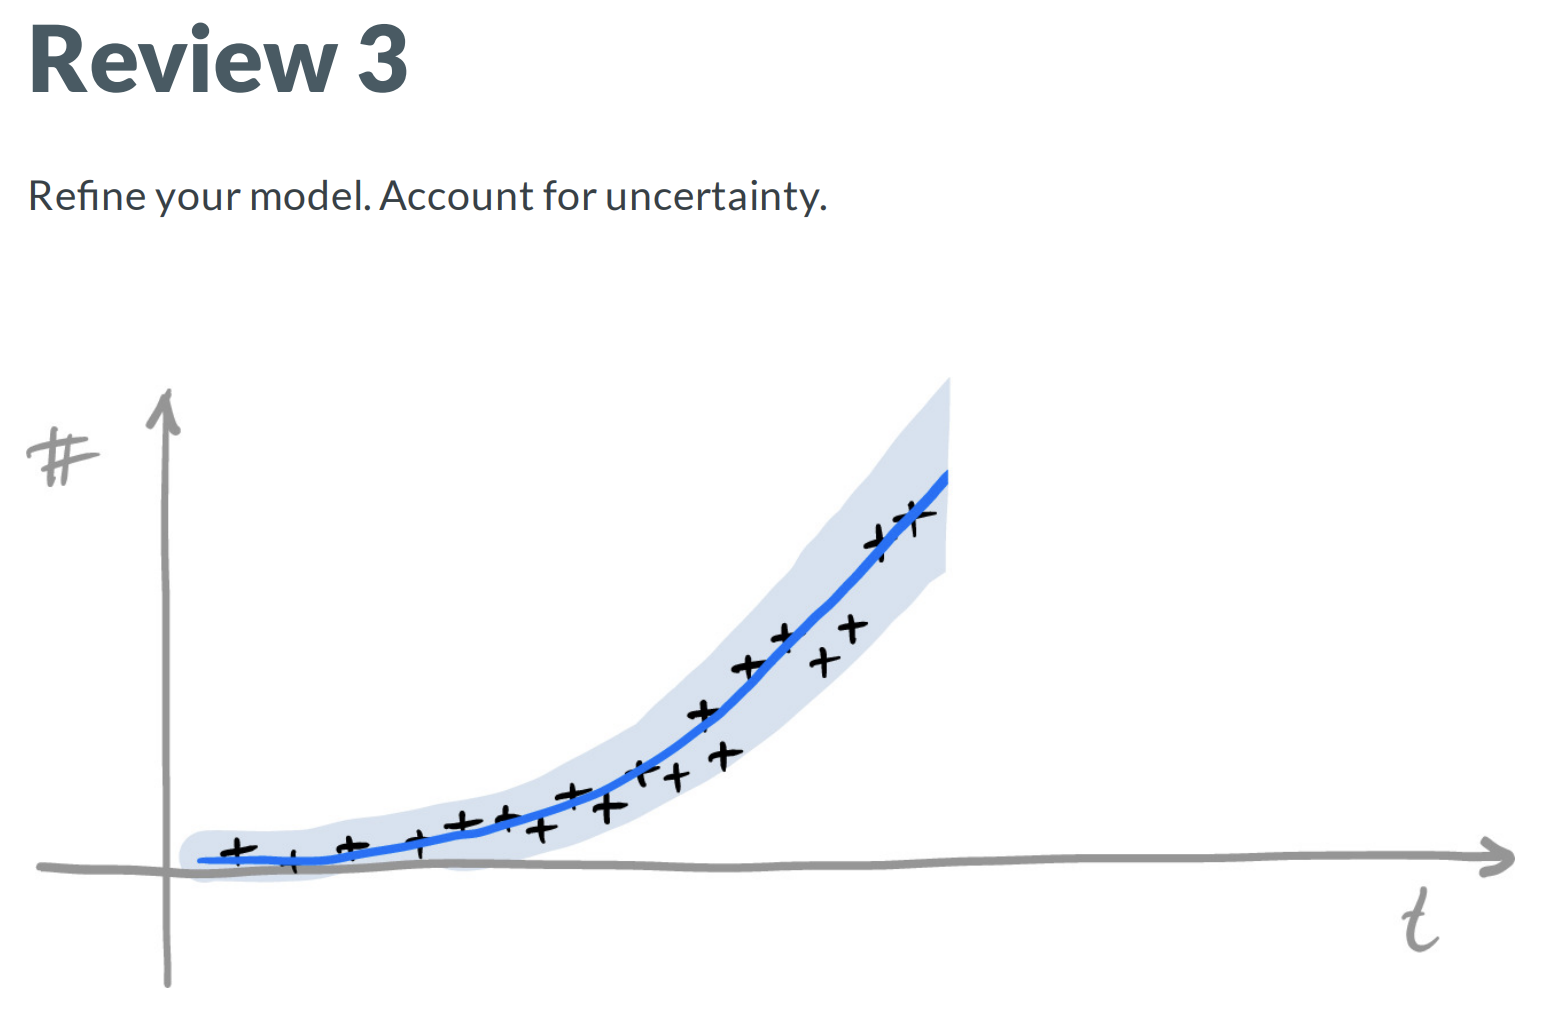

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
import math
from scipy.stats import binom

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import FloatSlider
from ipywidgets import IntSlider
from ipywidgets import Checkbox

## Parameters

In [2]:
dataset = None

# Initial values of parameters
I_0 = 0
E_0 = 0
R_0 = 0
H_0 = 0
S_0 = 0
C_0 = 0
D_0 = 0
CT_0 = 0  # Contamination
CH_0 = 0

# Smoothing
smoothing = True

## Important values

In [3]:
N = 1000000

## Smoothing functions

In [4]:
def own_NRMAS(vector, window):
        '''
        Moving average, ignoring non-existing indexes, computing mean
        on existing indexes. 

        Parameters
        ----------
        vector : float
            Vector to smooth.
        window : integer
            Size of the window used to compute the mean.

        Returns
        -------
        vector
            A smoothed vector.

        '''
        smoothed_vector = np.zeros(len(vector))

        if (window % 2) == 0:
            print("Error window size even")
            return

        for i in range(len(vector)):
            smoothed_vector[i] = own_NRMAS_index(vector, window, i)

        return smoothed_vector
    
def own_NRMAS_index(vector, window, index):
        '''
        Auxiliary function of NRMAS

        Parameters
        ----------
        vector : float
            Vector to smooth.
        window : integer
            Size of the window used to compute the mean.
        index : integer
            Index of the value to smooth in the vector.

        Returns
        -------
        float
            A smoothed value depending on the vector.

        '''
        smoothed_value = 0
        nb_considered_values = 0
        max_size = (window - 1) / 2
        smoothing_window = np.arange(-max_size, max_size + 1, 1)

        for j in range(window):

            sliding_index = int(index + smoothing_window[j])

            if (sliding_index >= 0) and (sliding_index <= len(vector) - 1):
                smoothed_value += vector[sliding_index]
                nb_considered_values += 1

        return smoothed_value / nb_considered_values

def dataframe_smoothing(df):
    
    np_df = df.to_numpy()
    smoothed = np.copy(np_df)
    
    for i in range(1, np_df.shape[1]):
        smoothed[:, i] = own_NRMAS(np_df[:, i], 7)

    # Write new values in a dataframe
    new_df = pd.DataFrame(smoothed, columns=df.columns)

    return new_df

## Import dataset

In [5]:
def import_dataset():

    url = "https://raw.githubusercontent.com/ADelau/proj0016-epidemic-data/main/data.csv"
    # Import the dataframe:
    raw = pd.read_csv(url, sep=',', header=0)
    raw['num_positive'][0] = 1
    # Ad a new column at the end with cumulative positive cases at the right
    cumul_positive = np.copy(raw['num_positive'].to_numpy())

    for i in range(1, len(cumul_positive)):
        cumul_positive[i] += cumul_positive[i-1]

    raw.insert(7, 'cumul_positive', cumul_positive)

    if smoothing:
        dataframe = dataframe_smoothing(raw)
    else:
        dataframe = raw

    dataset = dataframe.to_numpy()

    return dataset

def get_initial_state(dataset, s, t):

    I_0 = int(dataset[0][1] / (s * t))
    E_0 = int(I_0 * 1)
    R_0 = 0
    H_0 = 0
    S_0 = int(1000000 - I_0 - E_0 - H_0)
    C_0 = 0
    D_0 = 0
    CT_0 = I_0  # Contamined
    CH_0 = int(dataset[0][4])
    
    return S_0, E_0, I_0, R_0, H_0, C_0, D_0, CT_0, CH_0


## Diferentials equations

In [6]:
def differential(state, time, beta, sigma, gamma, hp, hcr, pc, pd, pcr,s,t):

    S, E, I, R, H, C, D, CT, CH = state

    dS = -(beta * S * I) / (S + I + E + R + H + C + D)
    dE = ((beta * S * I) / (S + I + E + R + H + C + D)) - (sigma * E)
    dI = (sigma * E) - (gamma * I) - (hp * I)
    dH = (hp * I) - (hcr * H) - (pc * H)
    dC = (pc * H) - (pd * C) - (pcr * C)
    dD = (pd * C)
    dR = (gamma * I) + (hcr * H) + (pcr * C)

    dCT = sigma * E - CT
    dCH = hp * I

    return dS, dE, dI, dR, dH, dC, dD, dCT, dCH



# 1.Determinist Model

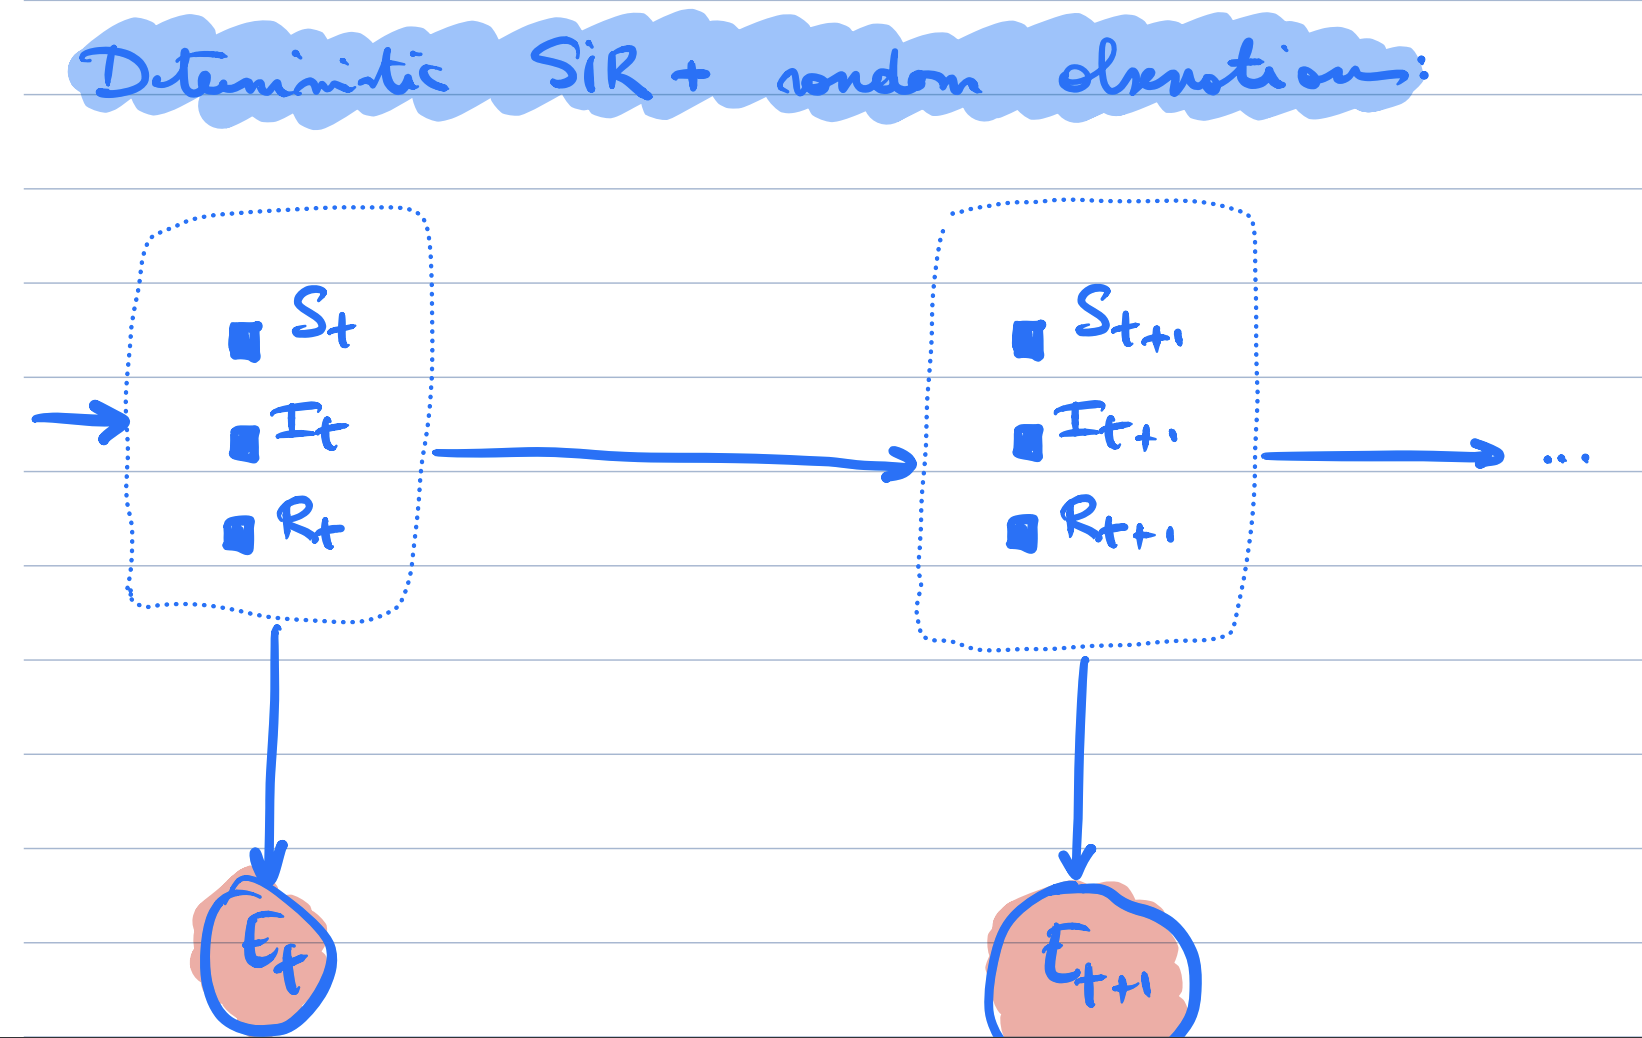
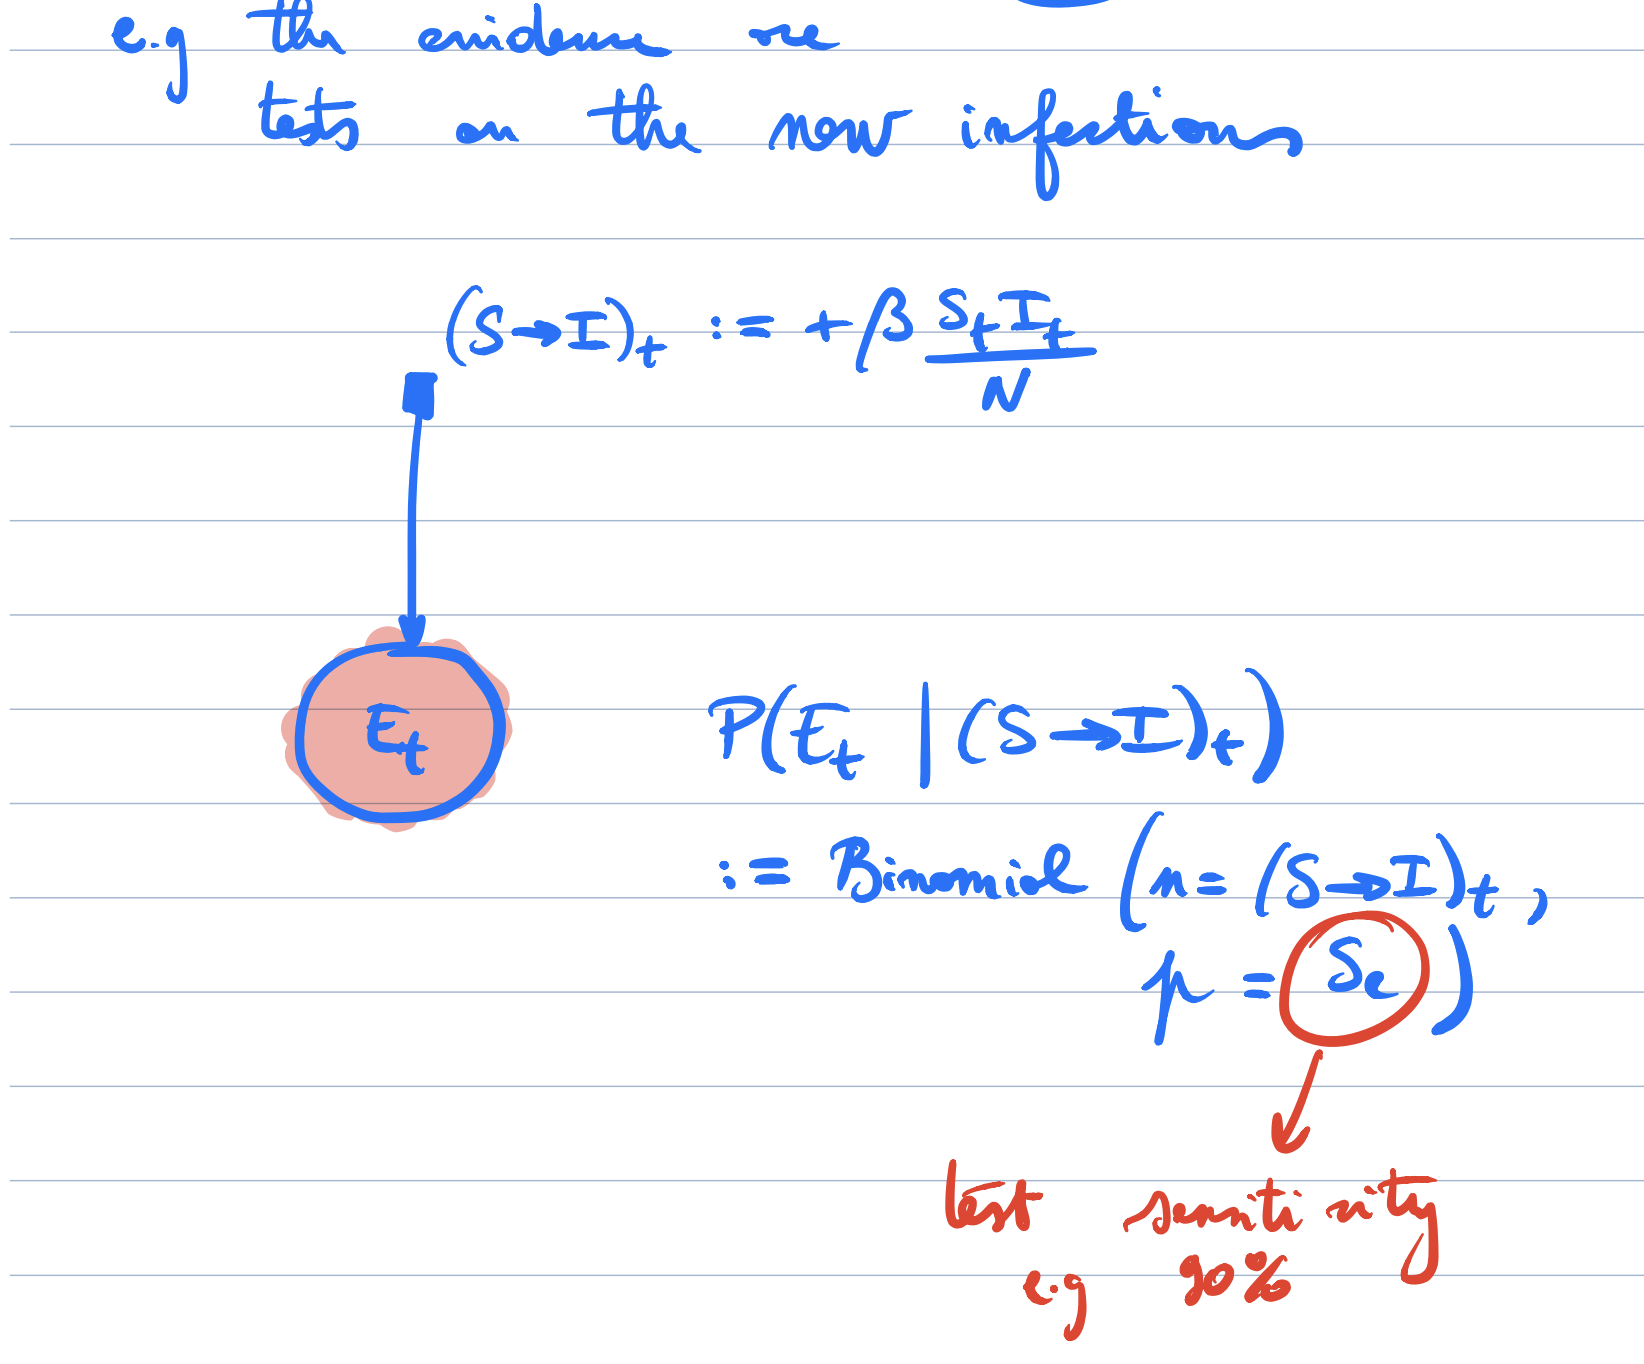
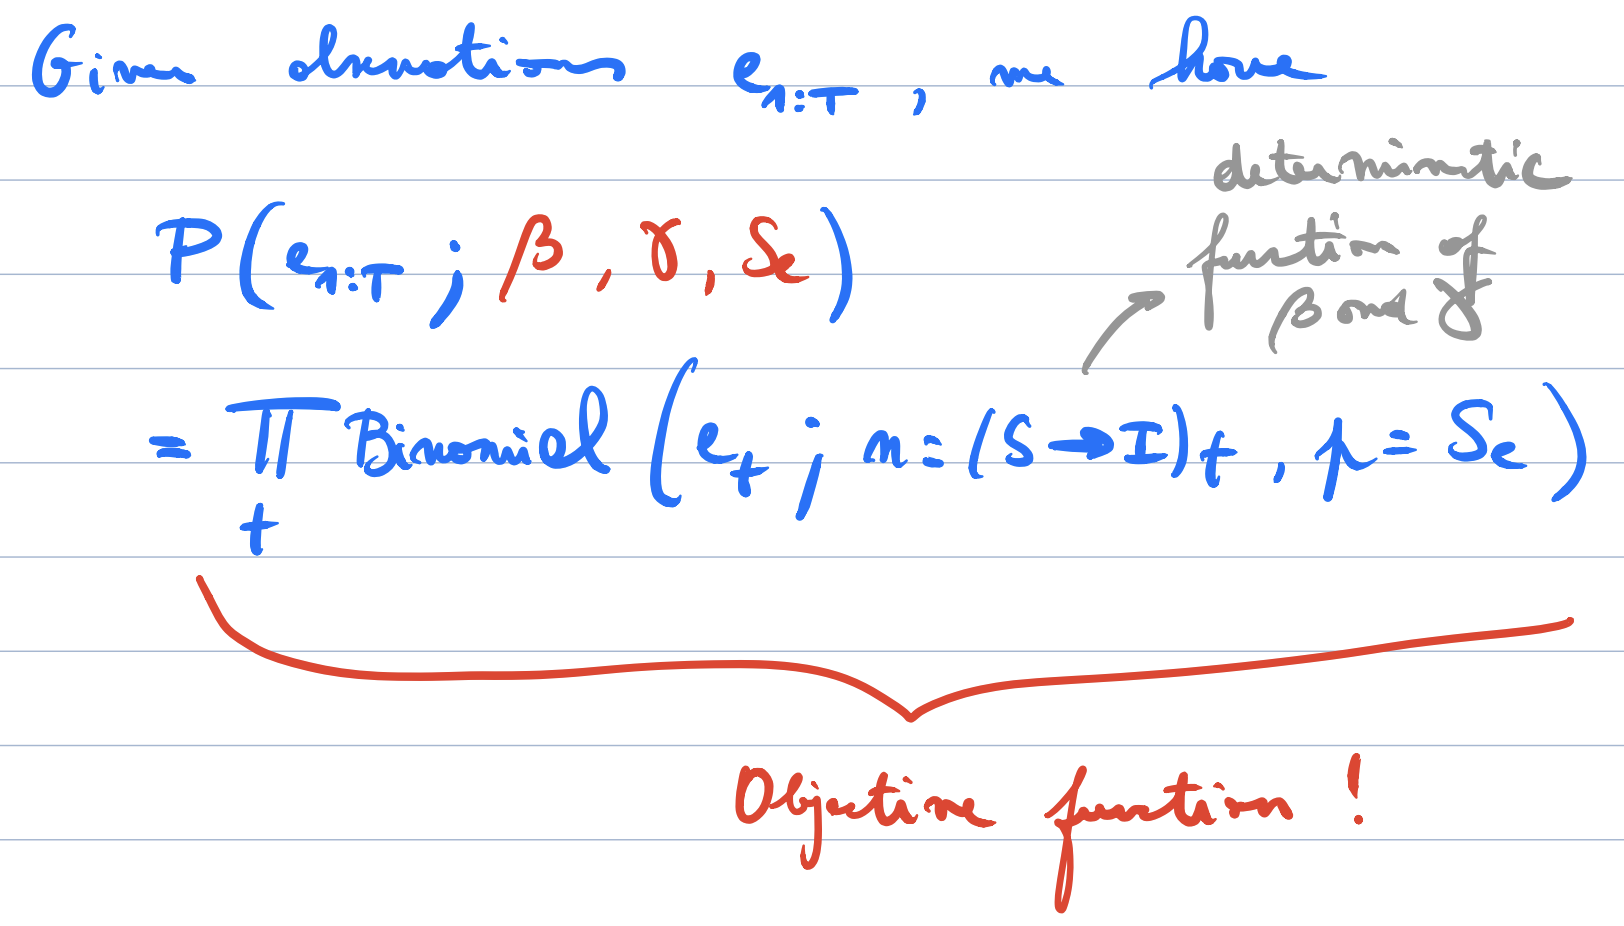
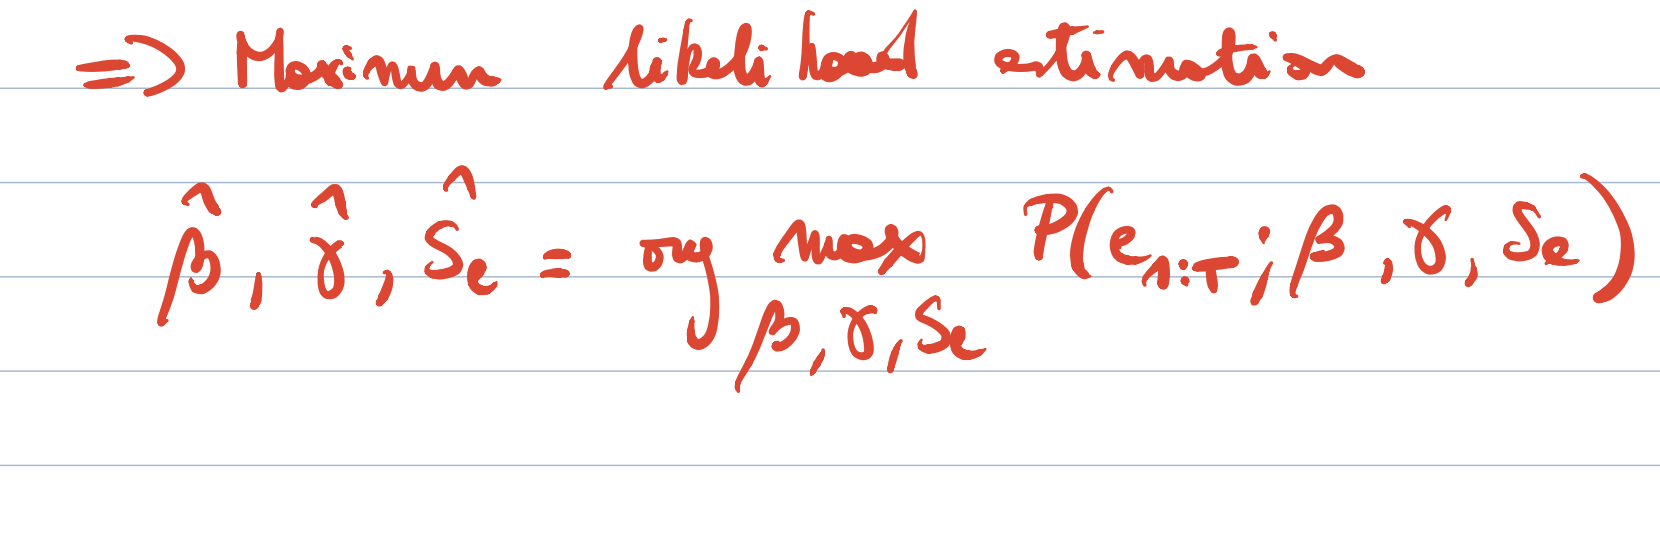

$(S\rightarrow I)_t$ is the number of individuals going from S to I at time t. Knowing this, the binomial law $\mathcal{B}\left(n=(S\rightarrow I)_t, p=Se\right)$ will return the number of well done tests knowing the sensitivity.

### SEIR model for defined values of parameters
Here we consider the fitting between the num_positive curve and the quantity $(E\rightarrow I)_t$, given by $\sigma E$. As can be seen on the graph below, we can compare num_positive and Conta for given values of $(\beta, \sigma, \gamma, Se)$. The Comta cuvre does not depend on the sensitivity, so we plotted a binomial Conta curve which implements the "loss" of the sensitivity test using the mean of the binomial law: $\mathcal{B}\left(n=(S\rightarrow I)_t, p=Se\right) = \mathcal{B}\left(\sigma E, Se\right) $

In [7]:
def print_SEIR(beta, sigma, gamma, hp, hcr, pc, pd, pcr, s, t, duration, S_, E_, I_, R_, H_, C_, D_, Conta_, Pred_hospit_, NP_, BC_, CH_):
    
    dataset = import_dataset()
    

    params = (beta, sigma, gamma, hp, hcr, pc, pd, pcr, s, t)
    time = np.arange(1, duration+1, 1)
    
    init = tuple(get_initial_state(dataset, s, t))
    print(init)
    print(params)

    predict = odeint(func=differential,
                     y0=init,
                     t=time,
                     args=params)

    with plt.style.context('dark_background'):

        fig_SEIR = plt.figure(figsize=(25, 20))
        ax1 = plt.subplot()
        if S_ == True:
            ax1.plot(time, predict[:,0], label='S')
        if E_ == True:
            ax1.plot(time, predict[:,1], label='E')
        if I_ == True:
            ax1.plot(time, predict[:,2], label='I')
        if R_ == True:
            ax1.plot(time, predict[:,3], label='R')
        if H_ == True:
            ax1.plot(time, predict[:,4], label='H')
        if C_ == True:
            ax1.plot(time, predict[:,5], label='C')
        if D_ == True:
            ax1.plot(time, predict[:,6], label='D')
        if Conta_ == True:
            ax1.plot(time, predict[:,7], label='Pred conta')
        if Pred_hospit_ == True:
            ax1.plot(time, predict[:,8], label='Pred cumul hospit')
        if NP_ == True:
            ax1.plot(dataset[:,0], dataset[:,1], label='num_positive')
        if CH_ == True:
            ax1.plot(dataset[:,0], dataset[:,4], label='cumul_hospit')

        num_pos_compare = np.zeros(duration)
        for i in range(duration):
            num_pos_compare[i], _ = binom.stats(predict[i][4], s)

        if BC_ == True:
            ax1.plot(time, num_pos_compare, label='binomial Conta')

        plt.legend(fontsize=20)
        plt.xlabel('Days', fontsize=30)
        for tick in ax1.xaxis.get_major_ticks():
            tick.label.set_fontsize(30)
        for tick in ax1.yaxis.get_major_ticks():
            tick.label.set_fontsize(30)
        plt.grid(True)
        plt.show()
        plt.close()


## Interactive


In [8]:
beta_widget = FloatSlider(min=0.0, max=1.0, step=0.01, value=0.45)
sigma_widget = FloatSlider(min=0.0, max=1.0, step=0.001, value=0.98)
gamma_widget = FloatSlider(min=0.0, max=1.0, step=0.001, value=0.24)
hp_widget = FloatSlider(min=0.0, max=1.0, step=0.001, value=0.02)
hcr_widget = FloatSlider(min=0.0, max=1.0, step=0.001, value=0.03)
pc_widget = FloatSlider(min=0.0, max=1.0, step=0.001, value=0.08)
pd_widget = FloatSlider(min=0.0, max=1.0, step=0.001, value=0.04)
pcr_widget = FloatSlider(min=0.0, max=1.0, step=0.001, value=0.24)
s_widget = FloatSlider(min=0.0, max=1.0, step=0.001, value=0.74)
t_widget = FloatSlider(min=0.0, max=1.0, step=0.001, value=0.89)

duration_widget = IntSlider(min=0, max=300, step=1, value=250)

interact(print_SEIR, beta=beta_widget, sigma=sigma_widget, gamma=gamma_widget,
         hp=hp_widget, hcr=hcr_widget, pc=pc_widget, pd=pd_widget, pcr=pcr_widget, s=s_widget, t=t_widget,
         duration=duration_widget, S_=True, E_=True, I_=True, R_=True, H_=True, C_=True, D_=True, Conta_=True, Pred_hospit_=True, NP_=True, BC_=True, CH_ = True);

interactive(children=(FloatSlider(value=0.45, description='beta', max=1.0, step=0.001), FloatSlider(value=0.98…

#### Reminder on binomial law:
$\mathcal{B}(10, 0.7)$

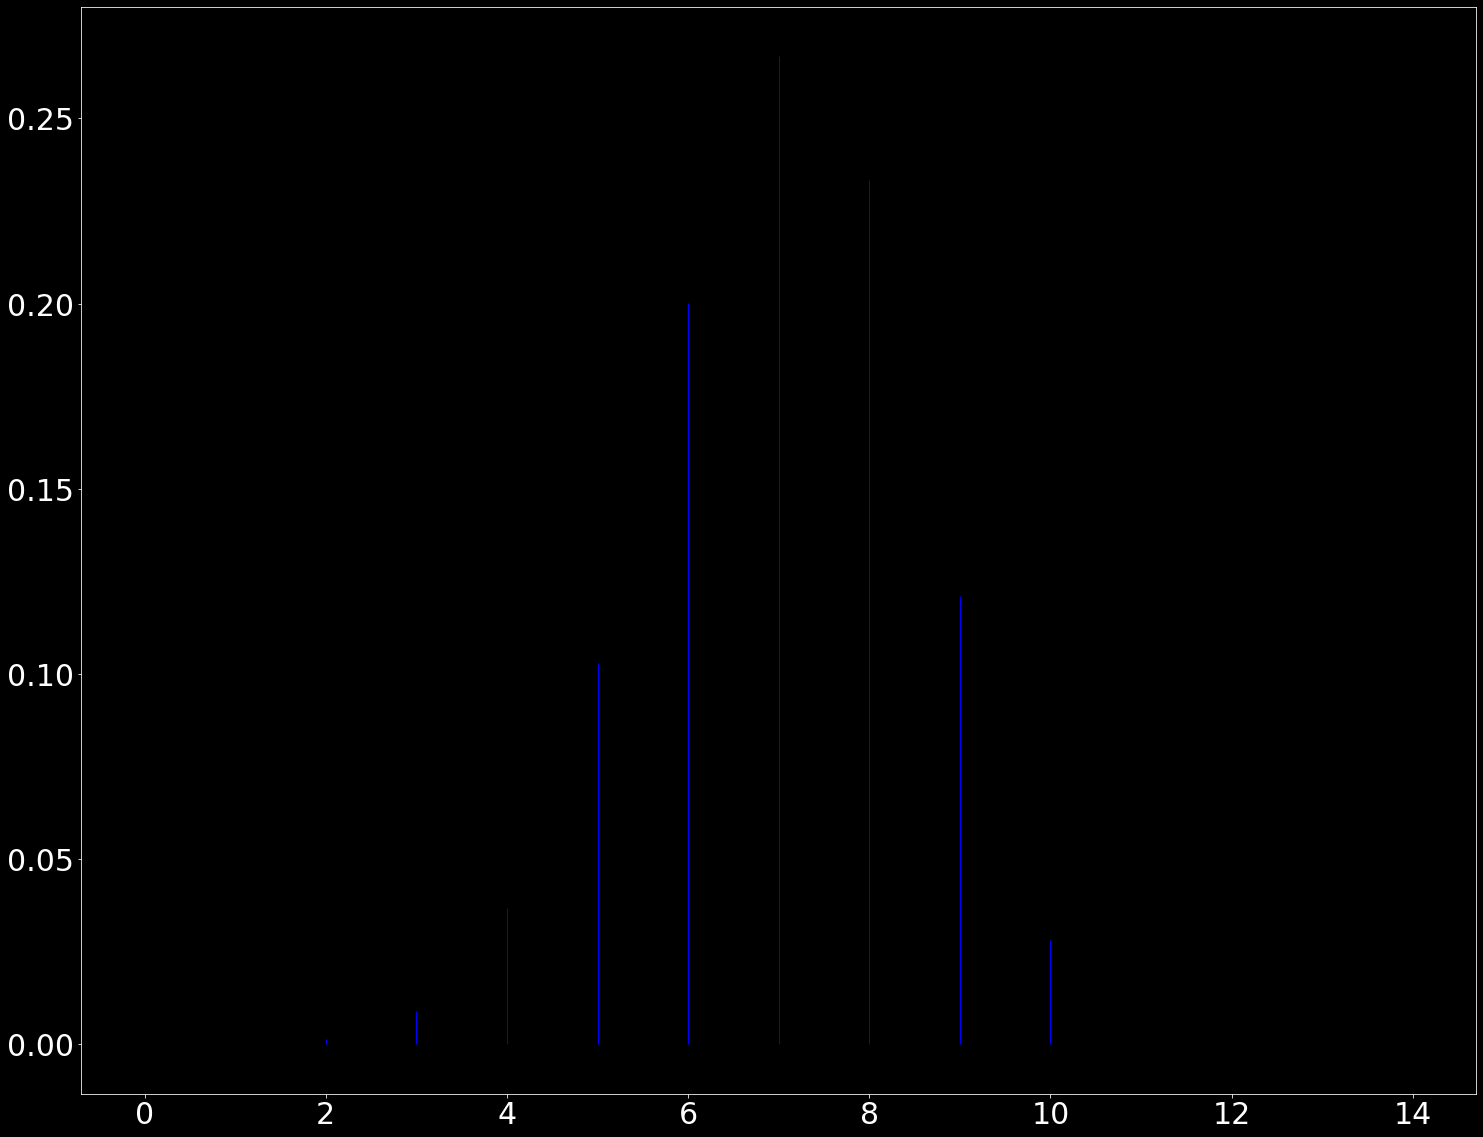

In [9]:
with plt.style.context('dark_background'):

    figbin = plt.figure(figsize=(25, 20))
    axbin = plt.subplot()

    x = np.arange(10+5)
    rv = binom(10, 0.7)
    axbin.vlines(x, 0, rv.pmf(x), colors='b', linestyles='-', lw=1,
            label='frozen pmf')

    for tick in axbin.xaxis.get_major_ticks():
        tick.label.set_fontsize(30)
    for tick in axbin.yaxis.get_major_ticks():
        tick.label.set_fontsize(30)

    plt.grid(False)
    plt.show()
    plt.close()

## Fitting

To fit this model we are going to use num_positive and the quantity of individuals going from E to I. We have:
$$
\begin{align}
    P(e_{1:t}; \beta, \gamma, \sigma, Se) &= \prod_t \mathcal{B}\left(e_t; n=(S\rightarrow I)_t, p=Se\right)\\
    &= \prod_t \mathcal{B}\left(e_t; \sigma E_t, Se\right)
\end{align}
$$
Do not confused e_t used for "evidences" at time t and E_t used for the quantity of individuals in the exposed state at time t. Therefore, we are going to try to maximize this probability and determine:
$$
\begin{align}
    \hat{\beta}, \hat{\gamma}, \hat{\sigma}, \hat{Se} &= \underset{\beta, \gamma, \sigma, Se}{argmax} P(e_{1:t}; \beta, \gamma, \sigma, Se)
\end{align}
$$

#### Problems we encounter
1. If for any value num_pos is higher than conta, then the probability is 0. So our approximation must be at least equal to the num_positive, or larger. 
2. We have a lot of observation, meaning that the product is long and can easily lead to 0.
3. We know that very little variations in the parameters leads to high differences

In [11]:
def cost(parameters, initial_state, time):
    print(parameters)
    tpl = tuple(parameters)
    params = (tpl[0], tpl[1], tpl[2], tpl[3], tpl[4], tpl[5], tpl[6])
    sensitivity = tpl[3]
    
    # Resolve EDOs
    predict = odeint(func=differential,
                     y0=initial_state,
                     t=time,
                     args=params)

    proba = 1
    
    # Vectors to fit
    to_fit_dataset = smoothed_dataset[:,1]
    model = predict[:,4]
    for i in range (len(model)):
        model[i] = round(model[i])
        
    print(to_fit_dataset)
    print(model)
    for i in range(len(time)):
        if (i%5 == 0):
            rv = binom(model[i], sensitivity)
            p_ = rv.pmf(to_fit_dataset[i])
            
            proba *= p_

    print(proba)
    return -proba

time = dataset[:,0]
bounds_ = [(0.1, 1), (0.1, 1), (0.1, 1), (0.7, 85)]
start_values = [0.46, 0.65, 0.2, 0.8]
init_state = get_initial_state()
res = minimize(cost, np.asarray(start_values), args=(init_state, time), bounds=bounds_)
#res = minimize(cost, np.asarray(start_values), args=(init_state, time), method='COBYLA')
print(res)

TypeError: 'NoneType' object is not subscriptable